In [1]:
import sirtipy
import RPproject as rpp
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import astropy.constants as const

In [2]:
# Assume constant absorption
def alpha_constant(frequency, location, Inu, alpha_val):
    return alpha_val

# Blackbody thermal emission from experiment 2
def j_thermal(frequency, location, Inu, temperature, alphafunc, alphafunc_args):
    B = sirtipy.blackbody_intensity(temperature, frequency)
    alpha = alphafunc(frequency, location, Inu, *alphafunc_args)
    return alpha*B

In [11]:
# Define medium
medium_temp = 800
alpha_0 = 1e-20

medium = sirtipy.region()
medium.add_emission_func(j_thermal, (medium_temp, alpha_constant, (alpha_0,)))
medium.add_absorption_func(alpha_constant, (alpha_0,))

freqaxis = sirtipy.frequency_axis('log', frange=[1.*u.cm, 1e-5*u.cm])


height = 100*u.pc 
s = [0, int(height.to(u.cm).value)]
ds = int(height.to(u.cm).value/500)

In [12]:
# Due to long computation time, calculate stellar intensity with fewer points and then use interpolation
faxis = np.geomspace(np.min(freqaxis.frequencies), np.max(freqaxis.frequencies), 100)

tstart = 0.7e9 # How many years before the light was emitted that star formation started
tstop  = 0.3e9 # How many years before the light was emtited that star formation ended
  
coeff = 1e-30
I_initial = rpp.generate_blackbody(faxis, tstart, tstop, rpp.exp_SFR)
I_no_balmer = rpp.generate_blackbody(faxis, tstart, tstop, rpp.exp_SFR, balmer=False)
star_spectrum = [coeff*np.interp(f, faxis, I_initial) for f in freqaxis.frequencies]
def j_stellar(frequency, location, Inu, dummy_arg):
    return np.interp(frequency, faxis, star_spectrum)

medium.add_emission_func(j_stellar,(None,))


In [13]:
# Create initial spectrum
inspec = sirtipy.spectrum('empty', frequencies=freqaxis)

In [14]:
spec, tau, locations = sirtipy.radiative_transfer(medium, inspec, s, ds, printevery=50)

 Try again with a smaller value of ds to see if result changes.
Location 50 of 500
Location 100 of 500
Location 150 of 500
Location 200 of 500
Location 250 of 500
Location 300 of 500
Location 350 of 500
Location 400 of 500
Location 450 of 500
Location 500 of 500


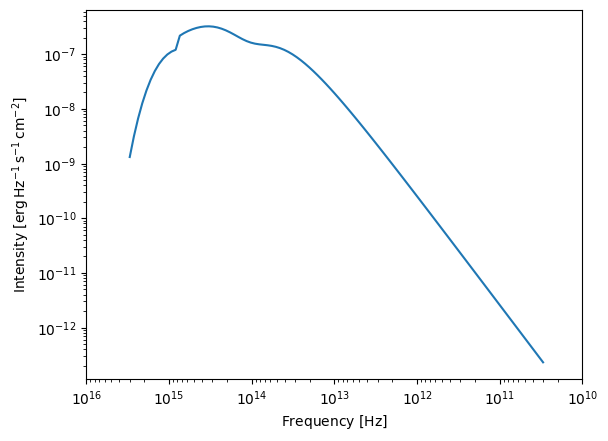

In [15]:
spec[-1].plot()
plt.xlim(1e16,1e10)
plt.yscale('log')
plt.xscale('log')

In [16]:
no_balmer_spec = [coeff*np.interp(f, faxis, I_no_balmer) for f in freqaxis.frequencies]

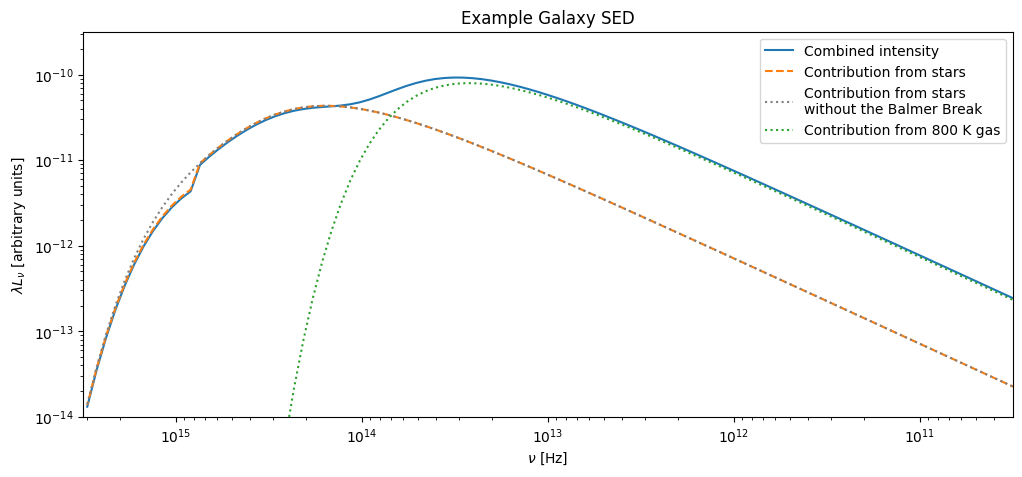

In [21]:
Inu = [s*const.c.cgs.value/f for f,s in zip(freqaxis.frequencies, spec[-1].intensity)]
stars = [10**20*s*const.c.cgs.value/f for f,s in zip(freqaxis.frequencies, star_spectrum)]
gas = [const.c.cgs.value/f * sirtipy.blackbody_intensity(medium_temp,f) for f in freqaxis.frequencies]
nob = [10**20*const.c.cgs.value/f * s for f,s in zip(freqaxis.frequencies, no_balmer_spec)]
plt.figure(figsize=(12,5))
plt.plot(freqaxis.frequencies, Inu, label='Combined intensity')
plt.plot(freqaxis.frequencies, stars, linestyle='--', label='Contribution from stars')
plt.plot(freqaxis.frequencies, nob, linestyle=':',c='grey', label='Contribution from stars\nwithout the Balmer Break')
plt.plot(freqaxis.frequencies, gas, linestyle=':', label='Contribution from 800 K gas')

plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.xlim(10**15.5,10**10.5)
plt.ylim(10**-14, 10**-9.5)
plt.ylabel(r'$\lambda L_\nu$ [arbitrary units]')
plt.xlabel(r'$\nu$ [Hz]')
plt.title('Example Galaxy SED')
plt.savefig('examplesed.png')
plt.show()